In [1]:
## All-Weather

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)


## 퀀트함수 ## 절대경로 참조
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
from quant_functions import anal_funcs, data_funcs

## Func

In [27]:
class PortfolioAllocator(object):
    def __init__(self) -> None:
        print("STEP1: dataload => eg. df = dataload('SPY', 'QQQ', 'IWM', 'VTI', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'GLD', 'DBC')")
        print("STEP2: cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)")
        print("eg. process, obtimal, min_risk = cal_optimal(df)")
        pass
    
    def dataload(self, *ticker):        
        ## 올웨더용 자산군 데이터
        df = data_funcs.get_merged_df(*ticker)
        df = df[list(ticker)].dropna()
        return df
    
    # target_sum을 만족하는 0 이상 k개 숫자의 모든 순열을 찾는 함수
    def permutations_k_sum(self, n, k, target_sum, prefix=[]):
        # 종료조건: k개의 숫자를 모두 선택했을 때, 합이 target_sum이면 prefix를 반환
        if k == 0:
            if target_sum == 0:
                return [prefix]  # prefix 리스트가 유효한 조합이므로 반환
            return []  # target_sum이 0이 아니라면 빈 리스트 반환
        if n < 0:
            return []  # 탐색 시작점이 음수인 경우 빈 리스트 반환
        if target_sum < 0:
            return []  # target_sum이 음수일 경우 빈 리스트 반환

        permutations = []  # 가능한 순열을 저장할 리스트

        # 숫자 i를 선택해 재귀적으로 다음 숫자들을 선택
        for i in range(n+1):
            # n부터 i를 선택하여 target_sum-i를 새로운 target으로 설정하고, prefix에 선택된 i를 추가
            permutations += self.permutations_k_sum(n, k-1, target_sum - i, prefix + [i])
        
        # 최종적으로 가능한 모든 순열을 반환
        return permutations
    
    ## 리벨런싱을 반영한 포트폴리오 구성 시뮬레이션 함수
    def cal_rebalancing(self, df, ratio=[0.5, 0.5], rebalancing=None, unit=None):
        # 주어진 데이터프레임(df)을 복사하여 작업을 수행
        new_df = df.copy()
        df_dict = []  # 리벨런싱 시점별 데이터프레임을 저장할 리스트
        years = sorted(new_df.index.year.unique())  # 유일한 연도 리스트
        months = sorted(new_df.index.month.unique())  # 유일한 월 리스트

        # 월 단위 리벨런싱을 수행할 때 일자 조정 (월간 집계로 인한 계산 오류 방지)
        if (rebalancing == 'm') & (unit == 'monthly'):
            temp_df = new_df.copy()
            temp_df.index = temp_df.index - dt.timedelta(days=1)  # 인덱스를 하루 전으로 조정
            new_df = pd.concat([new_df, temp_df])  # 수정된 데이터프레임을 기존 데이터와 결합
            new_df = new_df.sort_index()  # 인덱스를 기준으로 정렬
            new_df = new_df.shift(-1).dropna()  # 데이터 이동 및 결측값 제거

        # 리벨런싱 주기에 따라 데이터프레임을 분할
        if rebalancing == 'm':  # 월별 리벨런싱
            for year in years:
                for month in months:
                    temp = new_df[(new_df.index.year == year) & (new_df.index.month == month)]
                    if len(temp) > 0:
                        df_dict.append(temp)  # 각 월에 해당하는 데이터프레임 추가

        elif rebalancing == 'y':  # 연별 리벨런싱
            for year in years:
                temp = new_df[(new_df.index.year == year)]
                if len(temp) > 0:
                    df_dict.append(temp)  # 각 연도에 해당하는 데이터프레임 추가
        else:
            df_dict.append(new_df)  # 리벨런싱이 없으면 전체 데이터프레임을 추가

        # 리벨런싱을 적용하여 전략 가치 계산
        prev_val = 1  # 이전 리벨런싱의 마지막 가치를 저장하는 변수
        temp_series = pd.Series()  # 전략의 누적 가치를 저장할 시리즈
        for i in range(len(df_dict)):
            # 각 리벨런싱 구간의 첫날을 기준으로 비율을 조정하여 누적 수익률 계산
            temp = df_dict[i] / np.array(df_dict[i])[0]
            temp_AWP = (temp * ratio).sum(axis=1) * prev_val  # 비중을 적용한 가중 누적 수익률 계산
            prev_val = temp_AWP.iloc[-1]  # 다음 구간의 초기 가치를 현재 구간의 마지막 값으로 설정
            temp_series = pd.concat([temp_series, temp_AWP])  # 누적 시리즈에 추가

        # 전략의 누적 가치를 'strategy' 열에 추가
        new_df['strategy'] = temp_series

        # 월 단위로 계산한 데이터프레임을 원래 형태로 되돌림
        if (rebalancing == 'm') & (unit == 'monthly'):
            new_df['temp_y'] = new_df.index.year  # 임시 열로 연도 추가
            new_df['temp_m'] = new_df.index.month  # 임시 열로 월 추가
            new_df = new_df.drop_duplicates(['temp_y', 'temp_m'])  # 연도와 월 중복 제거
            new_df = new_df.drop(columns=['temp_y', 'temp_m'])  # 임시 열 제거
            new_df.index = df.index  # 인덱스를 원래 인덱스로 되돌림

        # 리벨런싱을 반영한 최종 데이터프레임 반환
        return new_df
    
    
    ## 최적화 비율 탐색 함수: 그리디 알고리즘
    def cal_optimal(self, df, unit='monthly', rebalancing='m', d=10, min_edge=30):
        '''   
        * df: 자산가치 시계열 데이터프레임
        * unit: 데이터 집계 주기 - 'daily' 또는 'monthly'
        * rebalancing: 리벨런싱 주기 - None, 'm' (월별), 'y' (연별)
        * d: 비중 시뮬레이션 단계 크기, 예를 들어 10은 10% 단위의 변동을 의미
        * min_edge: 첫 번째 자산의 최소 비중 (예: 50)
        '''

        k = len(df.T)  # 자산의 개수
        combinations = self.permutations_k_sum(100//d, k, 100//d)  # 비중 조합 생성
        combinations = pd.DataFrame(combinations) * d  # 비중을 백분율로 변환
        combinations = combinations[combinations[0] >= min_edge]  # 첫 번째 자산의 최소 비중 적용

        # 시뮬레이션 결과를 저장할 리스트 초기화
        pyrr, pydd, pstn, pvol, psharp, pweight = [], [], [], [], [], []
        print(f"총 {len(combinations)}번 시행 예정")
        
        # 각 비중 조합에 대해 시뮬레이션 실행
        for p in range(len(combinations)):
            if p == 0:
                print(f"1번째 시행 중")
            if (p % 100 == 99):
                print(f"{p + 1}번째 시행 중")
                
            # 현재 비중 설정
            weights = np.array(combinations)[p] 
            weights = weights / np.sum(weights)  # 비중 합계를 1로 조정

            # 리벨런싱 적용하여 전략 데이터프레임 생성
            result_df = self.cal_rebalancing(df, weights, rebalancing=rebalancing, unit=unit)
            # 위험 지표 및 성과 지표 계산
            sortino = anal_funcs.get_Vol_report(result_df, 'a', unit=unit)

            # 각 지표의 마지막 값(최종 성과)을 리스트에 추가
            pyrr.append(sortino['Return'][len(sortino)-1])  # 최종 수익률
            pydd.append(sortino['Volatility(Down)'][len(sortino)-1])  # 다운사이드 변동성
            pstn.append(sortino['Sortino_Ratio'][len(sortino)-1])  # Sortino 비율
            pvol.append(sortino['Volatility'][len(sortino)-1])  # 총 변동성
            psharp.append(sortino['Sharpe_Ratio'][len(sortino)-1])  # Sharpe 비율
            pweight.append(weights)  # 최종 비중 저장

        # 리스트를 배열로 변환하여 데이터 프레임에 저장
        pyrr = np.array(pyrr)
        pydd = np.array(pydd)
        pstn = np.array(pstn)
        pvol = np.array(pvol)
        psharp = np.array(psharp)
        pweight = np.array(pweight)

        # 결과 데이터를 데이터프레임으로 정리
        process = pd.DataFrame(pweight, columns=df.columns)
        process['Return'] = pyrr
        process['Volatility'] = pvol
        process['Volatility(Down)'] = pydd
        process['Sharpe Ratio'] = psharp
        process['Sortino Ratio'] = pstn
        
        # 최적의 Sortino 비율을 갖는 포트폴리오 선택
        obtimal = process[process['Sortino Ratio'] == process['Sortino Ratio'].max()]
        obtimal = obtimal.reset_index(drop=True)
        
        # 최저 변동성을 갖는 포트폴리오 선택
        min_risk = process[process['Volatility'] == process['Volatility'].min()]
        min_risk = min_risk.reset_index(drop=True)

        return process, obtimal, min_risk


## Proc

In [28]:
allocator = PortfolioAllocator()

STEP1: dataload => eg. df = dataload('SPY', 'QQQ', 'IWM', 'VTI', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'GLD', 'DBC')
STEP2: cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)
eg. process, obtimal, min_risk = cal_optimal(df)


In [30]:
df = allocator.dataload('SPY', 'QQQ', 'IWM', 'VTI', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'GLD', 'DBC')

[*********************100%%**********************]  11 of 11 completed


In [33]:
process, obtimal, min_risk = allocator.cal_optimal(df, unit='daily', rebalancing='y', d=10, min_edge=30)

총 19448번 시행 예정
1번째 시행 중
100번째 시행 중
200번째 시행 중
300번째 시행 중
400번째 시행 중
500번째 시행 중
600번째 시행 중
700번째 시행 중
800번째 시행 중
900번째 시행 중
1000번째 시행 중
1100번째 시행 중
1200번째 시행 중
1300번째 시행 중
1400번째 시행 중
1500번째 시행 중
1600번째 시행 중
1700번째 시행 중
1800번째 시행 중
1900번째 시행 중
2000번째 시행 중
2100번째 시행 중
2200번째 시행 중
2300번째 시행 중
2400번째 시행 중
2500번째 시행 중
2600번째 시행 중
2700번째 시행 중
2800번째 시행 중
2900번째 시행 중
3000번째 시행 중
3100번째 시행 중
3200번째 시행 중
3300번째 시행 중
3400번째 시행 중
3500번째 시행 중
3600번째 시행 중
3700번째 시행 중
3800번째 시행 중
3900번째 시행 중
4000번째 시행 중
4100번째 시행 중
4200번째 시행 중
4300번째 시행 중
4400번째 시행 중
4500번째 시행 중
4600번째 시행 중
4700번째 시행 중
4800번째 시행 중
4900번째 시행 중
5000번째 시행 중
5100번째 시행 중
5200번째 시행 중
5300번째 시행 중
5400번째 시행 중
5500번째 시행 중
5600번째 시행 중
5700번째 시행 중
5800번째 시행 중
5900번째 시행 중
6000번째 시행 중
6100번째 시행 중
6200번째 시행 중
6300번째 시행 중
6400번째 시행 중
6500번째 시행 중
6600번째 시행 중
6700번째 시행 중
6800번째 시행 중
6900번째 시행 중
7000번째 시행 중
7100번째 시행 중
7200번째 시행 중
7300번째 시행 중
7400번째 시행 중
7500번째 시행 중
7600번째 시행 중
7700번째 시행 중
7800번째 시행 중
7900번째 시행 중
8000번째 시행 중
8100번째 시행 중
8200번째 시행 중
8

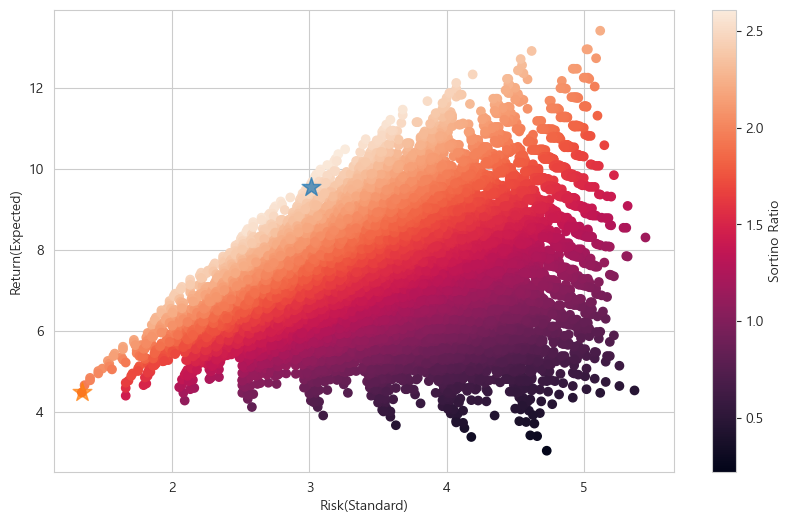

In [34]:
plt.scatter(process['Volatility'], process['Return'], c=process['Sharpe Ratio'], marker='o')
plt.grid(True)
plt.xlabel('Risk(Standard)')
plt.ylabel('Return(Expected)')
plt.colorbar(label='Sortino Ratio')

plt.scatter(obtimal['Volatility'][0], obtimal['Return'][0], marker="*", s=200, alpha=0.7)
plt.scatter(min_risk['Volatility'][0], min_risk['Return'][0], marker="*", s=200, alpha=0.7)

plt.show()

In [39]:
obtimal.values[0]

array([0.3 , 0.2 , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.1 , 0.  , 0.3 , 0.  ,
       9.57, 3.01, 1.96, 2.52, 3.85])

In [41]:
ratio = pd.DataFrame(list(obtimal.values[0][:-5]),
             index=obtimal.columns[:-5], columns=['ratio'])
ratio = list(ratio['ratio'])
result = allocator.cal_rebalancing(df, ratio=ratio, rebalancing='y', unit='daily')

In [43]:
result/np.array(result)[0]

Ticker,SPY,QQQ,IWM,VTI,VEA,VWO,TLT,IEF,SHY,GLD,DBC,strategy
Date,,,,,,,,,,,,
2007-07-26,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2007-07-27,0.980340,0.979788,0.975681,0.981190,0.984760,0.989070,1.002872,1.001945,1.001119,0.996344,1.009604,0.989444
2007-07-30,0.995676,0.991221,0.992615,0.995706,1.001253,1.027111,1.000000,0.999393,0.999876,1.001828,0.998079,0.997435
2007-07-31,0.984461,0.970396,0.981666,0.982076,1.000000,1.012644,1.007239,1.003524,1.001492,1.002133,1.006147,0.991134
2007-08-01,0.989258,0.977950,0.987013,0.987869,1.004175,0.996571,1.005058,1.000743,1.000519,1.004265,1.004610,0.994227
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-07,5.591367,12.112938,3.817125,5.550302,1.786646,1.649094,1.747101,1.716460,1.314752,3.802742,0.992642,5.004108
2024-11-08,5.615587,12.127091,3.845223,5.576237,1.763138,1.608193,1.769291,1.720112,1.313791,3.776999,0.977437,5.007059
2024-11-11,5.620938,12.120015,3.903034,5.591836,1.762436,1.598913,1.760683,1.715364,1.312831,3.688347,0.961798,4.967535


## Report

In [44]:
ratio

[0.3, 0.2, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.3, 0.0]

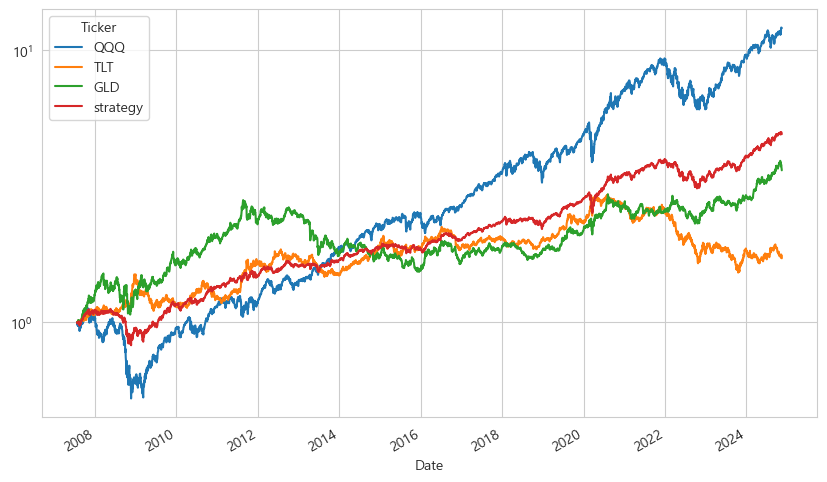

In [45]:
(result/np.array(result)[0])[['QQQ', 'TLT', 'GLD', 'strategy']].plot()
plt.yscale('log')
plt.show()

In [46]:
result.dropna()

Ticker,SPY,QQQ,IWM,VTI,VEA,VWO,TLT,IEF,SHY,GLD,DBC,strategy
Date,,,,,,,,,,,,
2007-07-26,106.523140,42.395988,61.926186,53.209713,28.500322,29.094769,52.275162,54.763878,62.468071,65.650002,23.019386,1.000000
2007-07-27,104.428886,41.539070,60.420189,52.208828,28.065975,28.776764,52.425301,54.870369,62.537983,65.410004,23.240471,0.989444
2007-07-30,106.062531,42.023804,61.468861,52.981251,28.536026,29.883553,52.275162,54.730640,62.460339,65.769997,22.975170,0.997435
2007-07-31,104.867928,41.140911,60.790802,52.255970,28.500322,29.462646,52.653576,54.956844,62.561279,65.790001,23.160879,0.991134
2007-08-01,105.378830,41.461174,61.121952,52.564201,28.619322,28.994999,52.539577,54.804562,62.500511,65.930000,23.125505,0.994227
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-07,595.609985,513.539978,236.380005,295.329987,50.919998,47.980000,91.330002,94.000000,82.129997,249.649994,22.850000,5.004108
2024-11-08,598.190002,514.140015,238.119995,296.709991,50.250000,46.790001,92.489998,94.199997,82.070000,247.960007,22.500000,5.007059
2024-11-11,598.760010,513.840027,241.699997,297.540009,50.230000,46.520000,92.040001,93.940002,82.010002,242.139999,22.139999,4.967535


In [47]:
## 연수익률
anal_funcs.get_YTD_report(result, 'a')

Ticker,SPY,QQQ,IWM,VTI,VEA,VWO,TLT,IEF,SHY,GLD,DBC,strategy
Date,,,,,,,,,,,,
2008,-36.79,-41.73,-34.14,-36.99,-40.62,-52.46,33.95,17.92,6.62,4.92,-31.80,-13.53
2009,26.35,54.68,28.49,28.90,27.51,76.31,-21.81,-6.59,0.35,24.03,16.19,21.28
2010,15.06,20.14,26.92,17.43,8.35,19.48,9.01,9.36,2.28,29.27,11.90,17.34
2011,1.90,3.48,-4.43,0.97,-12.31,-18.75,34.00,15.65,1.44,9.57,-2.58,8.78
2012,15.99,18.11,16.70,16.45,18.56,19.21,2.41,3.66,0.25,6.60,3.50,9.43
2013,32.31,36.63,38.70,33.45,21.81,-4.94,-13.38,-6.09,0.21,-28.33,-7.63,4.75
2014,13.46,19.18,5.04,12.55,-5.97,-0.04,27.30,9.07,0.45,-2.19,-28.10,10.83
2015,1.23,9.44,-4.48,0.36,-0.37,-15.82,-1.79,1.51,0.43,-10.67,-27.59,-1.17
2016,12.00,7.10,21.59,12.82,2.63,12.17,1.17,1.00,0.82,8.03,18.56,8.02


In [48]:
## 전고점대비 최대낙폭(MDD)
MDD, HRR = anal_funcs.get_MDD_report(result, 'a')
MDD

,MDD(%),Date
Ticker,,
SPY,-55.19,2009-03-09
QQQ,-53.40,2008-11-20
IWM,-58.39,2009-03-09
VTI,-55.45,2009-03-09
VEA,-60.69,2009-03-09
VWO,-67.68,2008-11-20
TLT,-48.35,2023-10-19
IEF,-23.92,2023-10-19
SHY,-5.71,2022-10-20


In [49]:
test_dfs = [result.reset_index().shift(i).set_index('Date')[-(len(result)+1 - int(len(result)/10)):]
            for i in range(int(len(result)/10))]

In [56]:
## sortino ratio
sort_df = anal_funcs.get_Vol_report(test_dfs[0][['QQQ', 'TLT', 'GLD', 'strategy']], 'a', unit='daily', rf=1)
## 모든 가능한 시작 시점에 대한 평가
temp = ([anal_funcs.get_Vol_report(test_dfs[i][['QQQ', 'TLT', 'GLD', 'strategy']], 'a', unit='daily', rf=1) for i in range(len(test_dfs))])
sort_df_simulation = (sum(temp)/len(temp)).round(2)

In [58]:
sort_df

,Return,Volatility,Volatility(Down),Residual,Beta,Sharpe_Ratio,Sortino_Ratio,Trainer_Ratio,Jensen_Alpha,Info_Ratio
Ticker,,,,,,,,,,
QQQ,20.09,5.01,3.05,0.00,1.00,3.81,6.25,19.09,0.00,NaN
TLT,1.92,3.97,2.06,6.43,-0.02,0.23,0.45,-60.62,1.21,-2.83
GLD,6.71,4.64,2.59,6.38,0.14,1.23,2.21,41.38,3.07,-2.10
strategy,11.14,2.83,1.57,3.20,1.43,3.58,6.46,7.11,-17.09,-2.80


In [57]:
sort_df_simulation

,Return,Volatility,Volatility(Down),Residual,Beta,Sharpe_Ratio,Sortino_Ratio,Trainer_Ratio,Jensen_Alpha,Info_Ratio
Ticker,,,,,,,,,,
QQQ,16.70,5.39,3.53,0.00,1.00,2.93,4.55,15.70,0.00,NaN
TLT,2.84,4.18,2.26,7.07,-0.10,0.44,0.81,-28.44,3.24,-1.99
GLD,5.72,4.86,2.81,6.92,0.10,0.97,1.70,48.87,3.05,-1.60
strategy,9.34,2.99,1.87,3.55,1.43,2.81,4.59,5.86,-14.02,-2.10
